In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:37 - loss: 0.2828 - STD: 1.1812e-04 - MAE: 0.5232

 4/74 [>.............................] - ETA: 2s - loss: 0.1062 - STD: 4.0686e-04 - MAE: 0.2642  

 5/74 [=>............................] - ETA: 2s - loss: 0.0874 - STD: 3.6595e-04 - MAE: 0.2271

 6/74 [=>............................] - ETA: 3s - loss: 0.0755 - STD: 3.2369e-04 - MAE: 0.2052

 7/74 [=>............................] - ETA: 3s - loss: 0.0676 - STD: 2.8680e-04 - MAE: 0.1915

 8/74 [==>...........................] - ETA: 3s - loss: 0.0620 - STD: 2.5594e-04 - MAE: 0.1827

 9/74 [==>...........................] - ETA: 3s - loss: 0.0580 - STD: 2.3043e-04 - MAE: 0.1769

10/74 [===>..........................] - ETA: 3s - loss: 0.0548 - STD: 2.0919e-04 - MAE: 0.1724

11/74 [===>..........................] - ETA: 3s - loss: 0.0524 - STD: 1.9127e-04 - MAE: 0.1692

12/74 [===>..........................] - ETA: 6s - loss: 0.0515 - STD: 1.7599e-04 - MAE: 0.1665

16/74 [=====>........................] - ETA: 5s - loss: 0.0454 - STD: 1.3312e-04 - MAE: 0.1594

17/74 [=====>........................] - ETA: 5s - loss: 0.0443 - STD: 1.2554e-04 - MAE: 0.1579

18/74 [======>.......................] - ETA: 4s - loss: 0.0432 - STD: 1.1885e-04 - MAE: 0.1564

19/74 [======>.......................] - ETA: 4s - loss: 0.0422 - STD: 1.1290e-04 - MAE: 0.1549

20/74 [=======>......................] - ETA: 4s - loss: 0.0413 - STD: 1.0762e-04 - MAE: 0.1534

21/74 [=======>......................] - ETA: 4s - loss: 0.0404 - STD: 1.0291e-04 - MAE: 0.1518

22/74 [=======>......................] - ETA: 4s - loss: 0.0395 - STD: 9.8646e-05 - MAE: 0.1501

23/74 [========>.....................] - ETA: 4s - loss: 0.0387 - STD: 9.4781e-05 - MAE: 0.1484

24/74 [========>.....................] - ETA: 4s - loss: 0.0378 - STD: 9.1300e-05 - MAE: 0.1465

25/74 [=========>....................] - ETA: 4s - loss: 0.0369 - STD: 8.8076e-05 - MAE: 0.1445

26/74 [=========>....................] - ETA: 4s - loss: 0.0361 - STD: 8.5151e-05 - MAE: 0.1425

27/74 [=========>....................] - ETA: 3s - loss: 0.0352 - STD: 8.2499e-05 - MAE: 0.1404

28/74 [==========>...................] - ETA: 3s - loss: 0.0344 - STD: 8.0052e-05 - MAE: 0.1382

29/74 [==========>...................] - ETA: 3s - loss: 0.0336 - STD: 7.7825e-05 - MAE: 0.1360

30/74 [===========>..................] - ETA: 3s - loss: 0.0328 - STD: 7.5775e-05 - MAE: 0.1340

31/74 [===========>..................] - ETA: 3s - loss: 0.0320 - STD: 7.3892e-05 - MAE: 0.1320

32/74 [===========>..................] - ETA: 3s - loss: 0.0313 - STD: 7.2148e-05 - MAE: 0.1303

33/74 [============>.................] - ETA: 3s - loss: 0.0306 - STD: 7.0518e-05 - MAE: 0.1288

34/74 [============>.................] - ETA: 3s - loss: 0.0300 - STD: 6.8960e-05 - MAE: 0.1275

35/74 [=============>................] - ETA: 3s - loss: 0.0294 - STD: 6.7476e-05 - MAE: 0.1264

36/74 [=============>................] - ETA: 3s - loss: 0.0289 - STD: 6.6089e-05 - MAE: 0.1254

37/74 [==============>...............] - ETA: 3s - loss: 0.0285 - STD: 6.4779e-05 - MAE: 0.1245

38/74 [==============>...............] - ETA: 2s - loss: 0.0280 - STD: 6.3496e-05 - MAE: 0.1237

39/74 [==============>...............] - ETA: 2s - loss: 0.0276 - STD: 6.2292e-05 - MAE: 0.1228

40/74 [===============>..............] - ETA: 2s - loss: 0.0272 - STD: 6.1107e-05 - MAE: 0.1219

41/74 [===============>..............] - ETA: 2s - loss: 0.0267 - STD: 5.9943e-05 - MAE: 0.1210

42/74 [================>.............] - ETA: 2s - loss: 0.0263 - STD: 5.8843e-05 - MAE: 0.1200

43/74 [================>.............] - ETA: 2s - loss: 0.0259 - STD: 5.7715e-05 - MAE: 0.1191

44/74 [================>.............] - ETA: 2s - loss: 0.0255 - STD: 5.6612e-05 - MAE: 0.1181

45/74 [=================>............] - ETA: 2s - loss: 0.0252 - STD: 5.5547e-05 - MAE: 0.1172

46/74 [=================>............] - ETA: 2s - loss: 0.0248 - STD: 5.4570e-05 - MAE: 0.1162

47/74 [==================>...........] - ETA: 2s - loss: 0.0245 - STD: 5.3579e-05 - MAE: 0.1153

48/74 [==================>...........] - ETA: 2s - loss: 0.0242 - STD: 5.2611e-05 - MAE: 0.1145

49/74 [==================>...........] - ETA: 2s - loss: 0.0239 - STD: 5.1662e-05 - MAE: 0.1136

50/74 [===================>..........] - ETA: 1s - loss: 0.0236 - STD: 5.0763e-05 - MAE: 0.1128

51/74 [===================>..........] - ETA: 1s - loss: 0.0233 - STD: 4.9877e-05 - MAE: 0.1121

52/74 [====================>.........] - ETA: 1s - loss: 0.0231 - STD: 4.9084e-05 - MAE: 0.1114

53/74 [====================>.........] - ETA: 1s - loss: 0.0228 - STD: 4.8316e-05 - MAE: 0.1106

54/74 [====================>.........] - ETA: 1s - loss: 0.0226 - STD: 4.7532e-05 - MAE: 0.1100

55/74 [=====================>........] - ETA: 1s - loss: 0.0223 - STD: 4.6782e-05 - MAE: 0.1093

56/74 [=====================>........] - ETA: 1s - loss: 0.0221 - STD: 4.6080e-05 - MAE: 0.1087

57/74 [======================>.......] - ETA: 1s - loss: 0.0219 - STD: 4.5382e-05 - MAE: 0.1081

58/74 [======================>.......] - ETA: 1s - loss: 0.0216 - STD: 4.4733e-05 - MAE: 0.1075

59/74 [======================>.......] - ETA: 1s - loss: 0.0214 - STD: 4.4105e-05 - MAE: 0.1069

60/74 [=======================>......] - ETA: 1s - loss: 0.0212 - STD: 4.3485e-05 - MAE: 0.1064

61/74 [=======================>......] - ETA: 1s - loss: 0.0210 - STD: 4.2888e-05 - MAE: 0.1059

62/74 [========================>.....] - ETA: 0s - loss: 0.0208 - STD: 4.2322e-05 - MAE: 0.1054

63/74 [========================>.....] - ETA: 0s - loss: 0.0206 - STD: 4.1774e-05 - MAE: 0.1050

64/74 [========================>.....] - ETA: 0s - loss: 0.0205 - STD: 4.1243e-05 - MAE: 0.1045

65/74 [=========================>....] - ETA: 0s - loss: 0.0203 - STD: 4.0704e-05 - MAE: 0.1041

66/74 [=========================>....] - ETA: 0s - loss: 0.0201 - STD: 4.0186e-05 - MAE: 0.1037

67/74 [==========================>...] - ETA: 0s - loss: 0.0200 - STD: 3.9675e-05 - MAE: 0.1033

68/74 [==========================>...] - ETA: 0s - loss: 0.0198 - STD: 3.9200e-05 - MAE: 0.1029

69/74 [==========================>...] - ETA: 0s - loss: 0.0197 - STD: 3.8752e-05 - MAE: 0.1026

70/74 [===========================>..] - ETA: 0s - loss: 0.0195 - STD: 3.8303e-05 - MAE: 0.1022

71/74 [===========================>..] - ETA: 0s - loss: 0.0194 - STD: 3.7865e-05 - MAE: 0.1018

72/74 [============================>.] - ETA: 0s - loss: 0.0192 - STD: 3.7438e-05 - MAE: 0.1015

73/74 [============================>.] - ETA: 0s - loss: 0.0191 - STD: 3.7008e-05 - MAE: 0.1011

74/74 [==============================] - ETA: 0s - loss: 0.0189 - STD: 3.6573e-05 - MAE: 0.1008

74/74 [==============================] - 8s 85ms/step - loss: 0.0189 - STD: 3.6573e-05 - MAE: 0.1008 - val_loss: 0.0086 - val_STD: 3.8583e-06 - val_MAE: 0.0713


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0094 - STD: 4.4815e-06 - MAE: 0.0758

 2/74 [..............................] - ETA: 5s - loss: 0.0094 - STD: 5.7862e-06 - MAE: 0.0757

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 6.0892e-06 - MAE: 0.0754

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 6.5267e-06 - MAE: 0.0752

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 6.8227e-06 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 6.9673e-06 - MAE: 0.0748

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 7.1693e-06 - MAE: 0.0748

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 7.2127e-06 - MAE: 0.0748

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 7.1232e-06 - MAE: 0.0747

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 6.9356e-06 - MAE: 0.0747

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 6.7864e-06 - MAE: 0.0747

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 6.6794e-06 - MAE: 0.0748

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 6.7047e-06 - MAE: 0.0748

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 6.5588e-06 - MAE: 0.0748

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.5345e-06 - MAE: 0.0749

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.5044e-06 - MAE: 0.0750

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.4455e-06 - MAE: 0.0751

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 6.3740e-06 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 6.3315e-06 - MAE: 0.0753

20/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 6.2886e-06 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.2724e-06 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.2566e-06 - MAE: 0.0753

23/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 6.2106e-06 - MAE: 0.0753

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 6.2020e-06 - MAE: 0.0753

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.2092e-06 - MAE: 0.0753

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.2128e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.1769e-06 - MAE: 0.0752

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.1488e-06 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.1585e-06 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.2016e-06 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.1976e-06 - MAE: 0.0752

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.1957e-06 - MAE: 0.0752

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.2288e-06 - MAE: 0.0752

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.2411e-06 - MAE: 0.0752

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.2369e-06 - MAE: 0.0752

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.2256e-06 - MAE: 0.0752

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.1871e-06 - MAE: 0.0752

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.1560e-06 - MAE: 0.0752

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.1476e-06 - MAE: 0.0752

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 6.1703e-06 - MAE: 0.0752

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 6.1847e-06 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.2050e-06 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.2236e-06 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.2328e-06 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.2389e-06 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.2660e-06 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.2919e-06 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.3014e-06 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.3021e-06 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.2733e-06 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.2629e-06 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.2509e-06 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.2547e-06 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.2543e-06 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.2544e-06 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.2548e-06 - MAE: 0.0753

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.2541e-06 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.2535e-06 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 6.2438e-06 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.2442e-06 - MAE: 0.0753

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.2460e-06 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.2467e-06 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.2569e-06 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.2669e-06 - MAE: 0.0753

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 6.2810e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 6.2976e-06 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.3052e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.3209e-06 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.3314e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.3447e-06 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.3477e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.3622e-06 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.3895e-06 - MAE: 0.0754

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 6.4056e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.9600e-06 - val_MAE: 0.0714


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0092 - STD: 8.0056e-06 - MAE: 0.0753

 2/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 8.0420e-06 - MAE: 0.0753

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 7.9742e-06 - MAE: 0.0750

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 7.9076e-06 - MAE: 0.0751

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 7.7808e-06 - MAE: 0.0751

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 7.8119e-06 - MAE: 0.0752

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 7.7482e-06 - MAE: 0.0752

 8/74 [==>...........................] - ETA: 3s - loss: 0.0091 - STD: 7.7950e-06 - MAE: 0.0751

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 7.9087e-06 - MAE: 0.0753

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 8.0280e-06 - MAE: 0.0753

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 8.1114e-06 - MAE: 0.0752

12/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 8.2262e-06 - MAE: 0.0752

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 8.2563e-06 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 8.3228e-06 - MAE: 0.0753

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 8.4014e-06 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 8.4289e-06 - MAE: 0.0752

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 8.4820e-06 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 8.5536e-06 - MAE: 0.0753

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 8.6062e-06 - MAE: 0.0753

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 8.6674e-06 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 8.7290e-06 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 8.7888e-06 - MAE: 0.0753

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 8.8558e-06 - MAE: 0.0753

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 8.9350e-06 - MAE: 0.0753

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 8.9985e-06 - MAE: 0.0753

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 9.0771e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 9.1599e-06 - MAE: 0.0753

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 9.2624e-06 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 9.3785e-06 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.4913e-06 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.6106e-06 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 9.7057e-06 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 9.7987e-06 - MAE: 0.0753

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 9.8725e-06 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.0009e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.0074e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.0144e-05 - MAE: 0.0753

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.0210e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.0284e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.0361e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.0456e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.0559e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.0671e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.0776e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.0888e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.0996e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.1106e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.1217e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.1318e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.1406e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.1487e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.1566e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.1646e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.1725e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.1801e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.1882e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.1960e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.2054e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.2151e-05 - MAE: 0.0753

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.2260e-05 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2381e-05 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2513e-05 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.2644e-05 - MAE: 0.0753

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.2781e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.2890e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.2978e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.3045e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.3115e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.3184e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.3259e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.3337e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.3420e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.3507e-05 - MAE: 0.0754

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 1.3507e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.3278e-05 - val_MAE: 0.0717


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0092 - STD: 2.1222e-05 - MAE: 0.0763

 2/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 2.1135e-05 - MAE: 0.0761

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 2.1315e-05 - MAE: 0.0758

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 2.1654e-05 - MAE: 0.0759

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 2.2085e-05 - MAE: 0.0759

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 2.2527e-05 - MAE: 0.0759

 7/74 [=>............................] - ETA: 4s - loss: 0.0094 - STD: 2.2886e-05 - MAE: 0.0760

 8/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 2.3259e-05 - MAE: 0.0760

 9/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 2.3622e-05 - MAE: 0.0760

10/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 2.4004e-05 - MAE: 0.0759

11/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 2.4360e-05 - MAE: 0.0759

12/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 2.4772e-05 - MAE: 0.0758

13/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 2.5183e-05 - MAE: 0.0757

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 2.5616e-05 - MAE: 0.0757

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 2.6028e-05 - MAE: 0.0758

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 2.6349e-05 - MAE: 0.0756

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6662e-05 - MAE: 0.0755

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.6954e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7252e-05 - MAE: 0.0755

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.7516e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.7797e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8105e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.8460e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.8838e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.9255e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.9665e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.0079e-05 - MAE: 0.0754

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.0479e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.0913e-05 - MAE: 0.0754

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.1361e-05 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.1789e-05 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.2156e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.2489e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.2811e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.3126e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.3473e-05 - MAE: 0.0753

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.3823e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.4179e-05 - MAE: 0.0753

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.4560e-05 - MAE: 0.0753

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 3.4932e-05 - MAE: 0.0753

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 3.5310e-05 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.5717e-05 - MAE: 0.0753

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.6150e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.6599e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.7083e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.7579e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.8089e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.8589e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.9059e-05 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.9546e-05 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 4.0035e-05 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.0522e-05 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.1031e-05 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.1536e-05 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 4.2040e-05 - MAE: 0.0753

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 4.2545e-05 - MAE: 0.0753

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 4.3069e-05 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.3602e-05 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.4164e-05 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.4734e-05 - MAE: 0.0753

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.5328e-05 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.5946e-05 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.6561e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.7210e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.7873e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.8534e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.9204e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.9876e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.0570e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 5.1262e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 5.1967e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 5.2697e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 5.3439e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 5.4219e-05 - MAE: 0.0754

74/74 [==============================] - 5s 63ms/step - loss: 0.0092 - STD: 5.4219e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 7.6025e-05 - val_MAE: 0.0715


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0094 - STD: 1.1503e-04 - MAE: 0.0764

 2/74 [..............................] - ETA: 4s - loss: 0.0094 - STD: 1.1615e-04 - MAE: 0.0760

 3/74 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 1.1798e-04 - MAE: 0.0760

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 1.1898e-04 - MAE: 0.0757

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 1.2047e-04 - MAE: 0.0758

 6/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 1.2184e-04 - MAE: 0.0759

 7/74 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 1.2348e-04 - MAE: 0.0759

 8/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.2532e-04 - MAE: 0.0759

 9/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.2717e-04 - MAE: 0.0760

10/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.2916e-04 - MAE: 0.0760

11/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.3100e-04 - MAE: 0.0759

12/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.3291e-04 - MAE: 0.0759

13/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 1.3499e-04 - MAE: 0.0759

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 1.3709e-04 - MAE: 0.0759

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.3911e-04 - MAE: 0.0758

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.4128e-04 - MAE: 0.0758

17/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.4351e-04 - MAE: 0.0757

18/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 1.4572e-04 - MAE: 0.0757

19/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 1.4819e-04 - MAE: 0.0757

20/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.5069e-04 - MAE: 0.0757

21/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.5316e-04 - MAE: 0.0757

22/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.5578e-04 - MAE: 0.0757

23/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.5852e-04 - MAE: 0.0756

24/74 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.6143e-04 - MAE: 0.0756

25/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.6447e-04 - MAE: 0.0756

26/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.6757e-04 - MAE: 0.0756

27/74 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 1.7071e-04 - MAE: 0.0756

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.7378e-04 - MAE: 0.0755

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.7690e-04 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.8016e-04 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.8356e-04 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 1.8725e-04 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0093 - STD: 1.9087e-04 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0093 - STD: 1.9459e-04 - MAE: 0.0755

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.9854e-04 - MAE: 0.0755

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.0659e-04 - MAE: 0.0755

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.1077e-04 - MAE: 0.0755

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.1516e-04 - MAE: 0.0755

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.1970e-04 - MAE: 0.0755

41/74 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 2.2439e-04 - MAE: 0.0755

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.2915e-04 - MAE: 0.0755

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.3412e-04 - MAE: 0.0755

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.3921e-04 - MAE: 0.0755

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.4455e-04 - MAE: 0.0755

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.5006e-04 - MAE: 0.0755

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.5576e-04 - MAE: 0.0755

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.6165e-04 - MAE: 0.0755

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.6772e-04 - MAE: 0.0755

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.7407e-04 - MAE: 0.0755

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.8067e-04 - MAE: 0.0755

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.8752e-04 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.9459e-04 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.0197e-04 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.0962e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.1753e-04 - MAE: 0.0754

57/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.2565e-04 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.3402e-04 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.4286e-04 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.5187e-04 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.6134e-04 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.7116e-04 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.8141e-04 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.9195e-04 - MAE: 0.0753

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.0310e-04 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.1468e-04 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.2662e-04 - MAE: 0.0753

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.3915e-04 - MAE: 0.0753

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.5206e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.6542e-04 - MAE: 0.0753

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.7928e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.9340e-04 - MAE: 0.0753

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 5.0821e-04 - MAE: 0.0752

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 5.2363e-04 - MAE: 0.0752

74/74 [==============================] - 5s 61ms/step - loss: 0.0092 - STD: 5.2363e-04 - MAE: 0.0752 - val_loss: 0.0084 - val_STD: 0.0011 - val_MAE: 0.0709


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0750

 3/74 [>.............................] - ETA: 3s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

 4/74 [>.............................] - ETA: 3s - loss: 0.0092 - STD: 0.0018 - MAE: 0.0751

 5/74 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

 6/74 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

 7/74 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0750

 8/74 [==>...........................] - ETA: 3s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

 9/74 [==>...........................] - ETA: 3s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0750

10/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0750

11/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0022 - MAE: 0.0749

12/74 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0748

13/74 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0748

14/74 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0748

15/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0748

16/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0747

17/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0747

18/74 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0747

19/74 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0747

20/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0747

21/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0747

22/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0747

23/74 [========>.....................] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0747

24/74 [========>.....................] - ETA: 2s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0746

25/74 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0746

26/74 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0746

27/74 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0745

28/74 [==========>...................] - ETA: 2s - loss: 0.0089 - STD: 0.0033 - MAE: 0.0745

29/74 [==========>...................] - ETA: 2s - loss: 0.0089 - STD: 0.0034 - MAE: 0.0745

30/74 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0744

31/74 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0744

32/74 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0744

33/74 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0743

34/74 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0743

35/74 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0743

36/74 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0742

37/74 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0742

38/74 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0043 - MAE: 0.0742

39/74 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0741

40/74 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.0045 - MAE: 0.0741

41/74 [===============>..............] - ETA: 1s - loss: 0.0088 - STD: 0.0047 - MAE: 0.0740

42/74 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0740

43/74 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0740

44/74 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0739

45/74 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0739

46/74 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0053 - MAE: 0.0738

47/74 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0737

48/74 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0737

49/74 [==================>...........] - ETA: 1s - loss: 0.0087 - STD: 0.0058 - MAE: 0.0736

50/74 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.0059 - MAE: 0.0736

51/74 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.0061 - MAE: 0.0736

52/74 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0735

53/74 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0735

54/74 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0734

55/74 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0734

56/74 [=====================>........] - ETA: 1s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0733

57/74 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0733

58/74 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0732

59/74 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0732

60/74 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0731

61/74 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0730

62/74 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0730

63/74 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0729

64/74 [========================>.....] - ETA: 0s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0728

65/74 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0088 - MAE: 0.0728

66/74 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.0090 - MAE: 0.0727

67/74 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0726

68/74 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0726

69/74 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0097 - MAE: 0.0725

70/74 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0099 - MAE: 0.0724

71/74 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0102 - MAE: 0.0724

72/74 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0104 - MAE: 0.0723

73/74 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0107 - MAE: 0.0722

74/74 [==============================] - ETA: 0s - loss: 0.0084 - STD: 0.0109 - MAE: 0.0721

74/74 [==============================] - 5s 62ms/step - loss: 0.0084 - STD: 0.0109 - MAE: 0.0721 - val_loss: 0.0065 - val_STD: 0.0190 - val_MAE: 0.0618


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0071 - STD: 0.0292 - MAE: 0.0665

 2/74 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0296 - MAE: 0.0664

 3/74 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0299 - MAE: 0.0662

 4/74 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0302 - MAE: 0.0663

 5/74 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0306 - MAE: 0.0662

 6/74 [=>............................] - ETA: 3s - loss: 0.0071 - STD: 0.0310 - MAE: 0.0661

 7/74 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0314 - MAE: 0.0660

 8/74 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0317 - MAE: 0.0658

 9/74 [==>...........................] - ETA: 3s - loss: 0.0070 - STD: 0.0321 - MAE: 0.0656

10/74 [===>..........................] - ETA: 3s - loss: 0.0070 - STD: 0.0325 - MAE: 0.0655

11/74 [===>..........................] - ETA: 3s - loss: 0.0069 - STD: 0.0329 - MAE: 0.0655

12/74 [===>..........................] - ETA: 3s - loss: 0.0069 - STD: 0.0332 - MAE: 0.0653

13/74 [====>.........................] - ETA: 3s - loss: 0.0069 - STD: 0.0336 - MAE: 0.0653

14/74 [====>.........................] - ETA: 3s - loss: 0.0069 - STD: 0.0339 - MAE: 0.0651

15/74 [=====>........................] - ETA: 3s - loss: 0.0069 - STD: 0.0343 - MAE: 0.0650

16/74 [=====>........................] - ETA: 3s - loss: 0.0069 - STD: 0.0346 - MAE: 0.0648

17/74 [=====>........................] - ETA: 3s - loss: 0.0068 - STD: 0.0350 - MAE: 0.0647

18/74 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0353 - MAE: 0.0646

19/74 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0357 - MAE: 0.0645

20/74 [=======>......................] - ETA: 3s - loss: 0.0068 - STD: 0.0360 - MAE: 0.0643

21/74 [=======>......................] - ETA: 3s - loss: 0.0067 - STD: 0.0363 - MAE: 0.0642

22/74 [=======>......................] - ETA: 2s - loss: 0.0067 - STD: 0.0367 - MAE: 0.0641

23/74 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0370 - MAE: 0.0640

24/74 [========>.....................] - ETA: 2s - loss: 0.0067 - STD: 0.0373 - MAE: 0.0639

25/74 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0376 - MAE: 0.0638

26/74 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0379 - MAE: 0.0637

27/74 [=========>....................] - ETA: 2s - loss: 0.0066 - STD: 0.0382 - MAE: 0.0636

28/74 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0384 - MAE: 0.0635

29/74 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0387 - MAE: 0.0634

30/74 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0390 - MAE: 0.0633

31/74 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0392 - MAE: 0.0632

32/74 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0395 - MAE: 0.0631

33/74 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0398 - MAE: 0.0630

34/74 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0401 - MAE: 0.0629

35/74 [=============>................] - ETA: 2s - loss: 0.0065 - STD: 0.0403 - MAE: 0.0628

36/74 [=============>................] - ETA: 2s - loss: 0.0065 - STD: 0.0406 - MAE: 0.0627

37/74 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.0407 - MAE: 0.0626

38/74 [==============>...............] - ETA: 2s - loss: 0.0065 - STD: 0.0410 - MAE: 0.0626

39/74 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0413 - MAE: 0.0625

40/74 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0414 - MAE: 0.0624

41/74 [===============>..............] - ETA: 1s - loss: 0.0064 - STD: 0.0416 - MAE: 0.0623

42/74 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0419 - MAE: 0.0623

43/74 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0420 - MAE: 0.0622

44/74 [================>.............] - ETA: 1s - loss: 0.0064 - STD: 0.0422 - MAE: 0.0620

45/74 [=================>............] - ETA: 1s - loss: 0.0064 - STD: 0.0425 - MAE: 0.0620

46/74 [=================>............] - ETA: 1s - loss: 0.0063 - STD: 0.0427 - MAE: 0.0619

47/74 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0428 - MAE: 0.0618

48/74 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0431 - MAE: 0.0617

49/74 [==================>...........] - ETA: 1s - loss: 0.0063 - STD: 0.0433 - MAE: 0.0617

50/74 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0435 - MAE: 0.0616

51/74 [===================>..........] - ETA: 1s - loss: 0.0063 - STD: 0.0437 - MAE: 0.0615

52/74 [====================>.........] - ETA: 1s - loss: 0.0063 - STD: 0.0439 - MAE: 0.0615

53/74 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0441 - MAE: 0.0614

54/74 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0442 - MAE: 0.0613

55/74 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0444 - MAE: 0.0612

56/74 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0446 - MAE: 0.0612

57/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0447 - MAE: 0.0611

58/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0449 - MAE: 0.0610

59/74 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0451 - MAE: 0.0610

60/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0452 - MAE: 0.0609

61/74 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0454 - MAE: 0.0608

62/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0456 - MAE: 0.0608

63/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0457 - MAE: 0.0607

64/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0459 - MAE: 0.0607

65/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0461 - MAE: 0.0606

66/74 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0462 - MAE: 0.0605

67/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0464 - MAE: 0.0605

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0465 - MAE: 0.0604

69/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0466 - MAE: 0.0604

70/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0468 - MAE: 0.0603

71/74 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0469 - MAE: 0.0603

72/74 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0471 - MAE: 0.0602

74/74 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0473 - MAE: 0.0601

74/74 [==============================] - 5s 60ms/step - loss: 0.0060 - STD: 0.0473 - MAE: 0.0601 - val_loss: 0.0046 - val_STD: 0.0464 - val_MAE: 0.0521


Epoch 8/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0574 - MAE: 0.0570

 2/74 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0569

 3/74 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0564

 4/74 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0564

 5/74 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0563

 6/74 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0562

 7/74 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0562

 8/74 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

 9/74 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0561

10/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0561

11/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0560

12/74 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

13/74 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

14/74 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0575 - MAE: 0.0561

15/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0575 - MAE: 0.0561

16/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0561

17/74 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

18/74 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0560

19/74 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0560

20/74 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0560

21/74 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0560

22/74 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0559

23/74 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0558

24/74 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0558

25/74 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0558

26/74 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0558

28/74 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0557

29/74 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0558

30/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0557

31/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0557

32/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

33/74 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

34/74 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0557

35/74 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0557

36/74 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0556

37/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0556

38/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0556

39/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0556

40/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0556

41/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0555

42/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0555

43/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0555

44/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0555

45/74 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0554

46/74 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0554

47/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0554

48/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0554

49/74 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0554

50/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0554

51/74 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0554

52/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0553

53/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0553

54/74 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0553

55/74 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0553

56/74 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0552

57/74 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

58/74 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0552

60/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0552

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0551

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0551

63/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0551

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0551

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0551

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0551

67/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0550

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0550

69/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0550

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0550

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0550

72/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0550

73/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0549

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0549

74/74 [==============================] - 5s 66ms/step - loss: 0.0051 - STD: 0.0597 - MAE: 0.0549 - val_loss: 0.0044 - val_STD: 0.0522 - val_MAE: 0.0516


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0539

 2/74 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0535

 3/74 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0539

 4/74 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0538

 5/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0536

 6/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0538

 7/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0536

 8/74 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0536

 9/74 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0536

10/74 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

11/74 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0536

12/74 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0539

13/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0540

14/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0541

15/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0541

16/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0541

17/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0541

18/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0541

19/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0540

20/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0540

21/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0539

22/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

23/74 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

24/74 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0539

25/74 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

26/74 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

27/74 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0539

28/74 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0622 - MAE: 0.0539

29/74 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0539

30/74 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0538

32/74 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0538

33/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537

34/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0537

35/74 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0537

36/74 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

37/74 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0537

38/74 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0536

39/74 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

40/74 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

41/74 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0536

42/74 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

43/74 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

44/74 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

45/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

46/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

47/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0534

48/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0534

49/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0534

50/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0534

51/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

52/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

53/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

54/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

55/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

56/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

57/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

58/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0533

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0533

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0533

61/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0533

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0533

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0532

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0532

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

70/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0532

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0631 - MAE: 0.0531

73/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0531

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0531

74/74 [==============================] - 5s 66ms/step - loss: 0.0048 - STD: 0.0632 - MAE: 0.0531 - val_loss: 0.0041 - val_STD: 0.0536 - val_MAE: 0.0484


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0515

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0526

 3/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0524

 4/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0525

 5/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0525

 6/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

 7/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0524

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0524

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0524

10/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0524

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0524

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0523

13/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0523

14/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0523

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0523

16/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0522

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0523

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0523

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0523

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

28/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

29/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

30/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0522

31/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

32/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0522

33/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

34/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

37/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

38/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

39/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

41/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

42/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0520

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0519

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0519

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0520

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0520

54/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0520

55/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0520

56/74 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

57/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

58/74 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

59/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

60/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0521

61/74 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

63/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

64/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

65/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

66/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

67/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

68/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

69/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

70/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

72/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0520

73/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

74/74 [==============================] - 5s 67ms/step - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521 - val_loss: 0.0039 - val_STD: 0.0544 - val_MAE: 0.0480


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0519

 2/74 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0536

 3/74 [>.............................] - ETA: 5s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0531

 4/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0526

 5/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0655 - MAE: 0.0535

 6/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0642 - MAE: 0.0531

 7/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0528

 8/74 [==>...........................] - ETA: 4s - loss: 0.0049 - STD: 0.0640 - MAE: 0.0533

 9/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0531

10/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0530

11/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

12/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0529

13/74 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

14/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

15/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0527

16/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0526

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0524

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0525

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0524

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0523

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0523

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0523

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0522

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0523

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0523

29/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

30/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

31/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0523

32/74 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0523

33/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

34/74 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0522

35/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

36/74 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0522

37/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

38/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

39/74 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0521

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0520

41/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

42/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0520

43/74 [================>.............] - ETA: 2s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

44/74 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

58/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

59/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0515

69/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

72/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

74/74 [==============================] - 5s 69ms/step - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515 - val_loss: 0.0039 - val_STD: 0.0557 - val_MAE: 0.0480


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0506

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0509

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0507

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

 6/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

 8/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

 9/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0508

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

11/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

12/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

13/74 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

14/74 [====>.........................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0508

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0507

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0508

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

23/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

25/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

27/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

28/74 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

29/74 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

43/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0507

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0507

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

58/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0505

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0505

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0505

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

74/74 [==============================] - 5s 69ms/step - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505 - val_loss: 0.0038 - val_STD: 0.0550 - val_MAE: 0.0460


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0668 - MAE: 0.0495

 2/74 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0500

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0504

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0505

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

10/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

13/74 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0506

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0506

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

24/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

25/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

26/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

27/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

28/74 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

34/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

36/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

41/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

42/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

43/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0500

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0500

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0500

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0500

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0500

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0500

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0500

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0499

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0500

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0500

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500

74/74 [==============================] - 5s 68ms/step - loss: 0.0044 - STD: 0.0682 - MAE: 0.0500 - val_loss: 0.0038 - val_STD: 0.0516 - val_MAE: 0.0453


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0632 - MAE: 0.0499

 2/74 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0494

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0499

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0502

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0500

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0499

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0500

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0499

10/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

12/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0499

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0498

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

25/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

26/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

27/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0494

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0494

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0494

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0494

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0494

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

74/74 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494 - val_loss: 0.0036 - val_STD: 0.0558 - val_MAE: 0.0446


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0672 - MAE: 0.0474

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0486

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0484

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0484

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0486

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0486

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0486

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0485

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0485

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0486

11/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

12/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0489

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0491

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0490

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0491

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0491

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0491

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

27/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0490

28/74 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

43/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

74/74 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491 - val_loss: 0.0041 - val_STD: 0.0485 - val_MAE: 0.0457


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0049 - STD: 0.0600 - MAE: 0.0501

 2/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0507

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0501

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0497

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0496

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0495

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

 9/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

10/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0493

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

12/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0494

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0495

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0495

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0495

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0496

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0499

24/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0498

25/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0498

26/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

27/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

28/74 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0499

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0499

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0499

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0499

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0498

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0498

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0497

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0496

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0496

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0496

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0495

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0495

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0495

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0495

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0494

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0494

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0494

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0494

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0493

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

74/74 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490 - val_loss: 0.0035 - val_STD: 0.0568 - val_MAE: 0.0441


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0471

 2/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0475

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0479

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0480

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0479

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0479

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0480

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0479

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0479

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0480

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0479

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0480

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0480

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0480

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0485

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0486

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0486

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

27/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

43/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0487

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0486

74/74 [==============================] - 5s 69ms/step - loss: 0.0042 - STD: 0.0699 - MAE: 0.0486 - val_loss: 0.0035 - val_STD: 0.0582 - val_MAE: 0.0453


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0486

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0480

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0691 - MAE: 0.0478

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0478

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

74/74 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477 - val_loss: 0.0034 - val_STD: 0.0599 - val_MAE: 0.0442


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0478

 2/74 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0477

 3/74 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0472

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0474

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0474

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0476

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0476

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0477

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

28/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

74/74 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475 - val_loss: 0.0034 - val_STD: 0.0619 - val_MAE: 0.0441


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0473

 2/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0477

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0478

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0479

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0483

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0478

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0478

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477

74/74 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0709 - MAE: 0.0477 - val_loss: 0.0034 - val_STD: 0.0602 - val_MAE: 0.0430


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0459

 2/74 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0465

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0466

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0466

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

29/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

74/74 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0431


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0463

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0464

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0464

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

13/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462 - val_loss: 0.0033 - val_STD: 0.0611 - val_MAE: 0.0429


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0457

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0460

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0470

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0473

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0464

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460 - val_loss: 0.0033 - val_STD: 0.0624 - val_MAE: 0.0423


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0454

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0456

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

74/74 [==============================] - 5s 63ms/step - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462 - val_loss: 0.0033 - val_STD: 0.0599 - val_MAE: 0.0417


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0703 - MAE: 0.0455

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0457

 4/74 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0456

 5/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0455

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0454

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0454

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0453

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0454

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0454

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0454

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0454

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

74/74 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457 - val_loss: 0.0033 - val_STD: 0.0633 - val_MAE: 0.0429


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0452

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0452

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0454

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0451

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0450

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - 5s 61ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0622 - val_MAE: 0.0429


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0458

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

74/74 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0642 - val_MAE: 0.0451


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0469

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

 5/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0451

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

74/74 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448 - val_loss: 0.0033 - val_STD: 0.0595 - val_MAE: 0.0415


Epoch 29/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0443

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0458

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0451

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0448

 5/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0447

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

22/74 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

39/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

74/74 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0663 - val_MAE: 0.0427


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0450

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0445

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0449

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0444

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0444

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0444

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0444

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/74 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442 - val_loss: 0.0031 - val_STD: 0.0639 - val_MAE: 0.0409


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0439

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0442

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0454

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0456

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0450

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0450

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

74/74 [==============================] - 5s 63ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446 - val_loss: 0.0032 - val_STD: 0.0630 - val_MAE: 0.0421


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0738 - MAE: 0.0436

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0724 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0439

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

74/74 [==============================] - 5s 66ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0660 - val_MAE: 0.0423


Epoch 33/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0438

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0439

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0438

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0438

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

74/74 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0618 - val_MAE: 0.0409


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0728 - MAE: 0.0427

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0431

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0443

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

14/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0448

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0449

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0450

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0453

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0455

29/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0456

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0456

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0463

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0468

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0468

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0469

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0470

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0470

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0469

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0471

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0470

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0470

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0470

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0469

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0468

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0463

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0463

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0463

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

74/74 [==============================] - 5s 70ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462 - val_loss: 0.0032 - val_STD: 0.0602 - val_MAE: 0.0407


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0426

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0434

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0435

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0436

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0408


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0424

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0639 - val_MAE: 0.0406


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0744 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

74/74 [==============================] - 5s 67ms/step - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0677 - val_MAE: 0.0422


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0437

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0442

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0442

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0650 - val_MAE: 0.0402


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0428

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0429

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0429

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

29/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

44/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

59/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0670 - val_MAE: 0.0417


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0432

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0427

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0433

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430 - val_loss: 0.0032 - val_STD: 0.0686 - val_MAE: 0.0422


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0434

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0436

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0433

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428 - val_loss: 0.0030 - val_STD: 0.0644 - val_MAE: 0.0405


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

 3/74 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0422

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0422

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0032 - val_STD: 0.0674 - val_MAE: 0.0432


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0443

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424 - val_loss: 0.0031 - val_STD: 0.0621 - val_MAE: 0.0403


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

74/74 [==============================] - 5s 64ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0681 - val_MAE: 0.0403


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0427

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0423

 4/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0424

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

39/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 4s 60ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0662 - val_MAE: 0.0403


Epoch 46/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0435

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0434

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0659 - val_MAE: 0.0406


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0418

 4/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0417

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 4s 60ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0032 - val_STD: 0.0678 - val_MAE: 0.0425


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0797 - MAE: 0.0433

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

 3/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0423

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

21/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

22/74 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - 5s 63ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0397


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0412

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

74/74 [==============================] - 5s 67ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418 - val_loss: 0.0033 - val_STD: 0.0705 - val_MAE: 0.0439


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0829 - MAE: 0.0449

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

15/74 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0654 - val_MAE: 0.0405


Epoch 51/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0664 - val_MAE: 0.0408


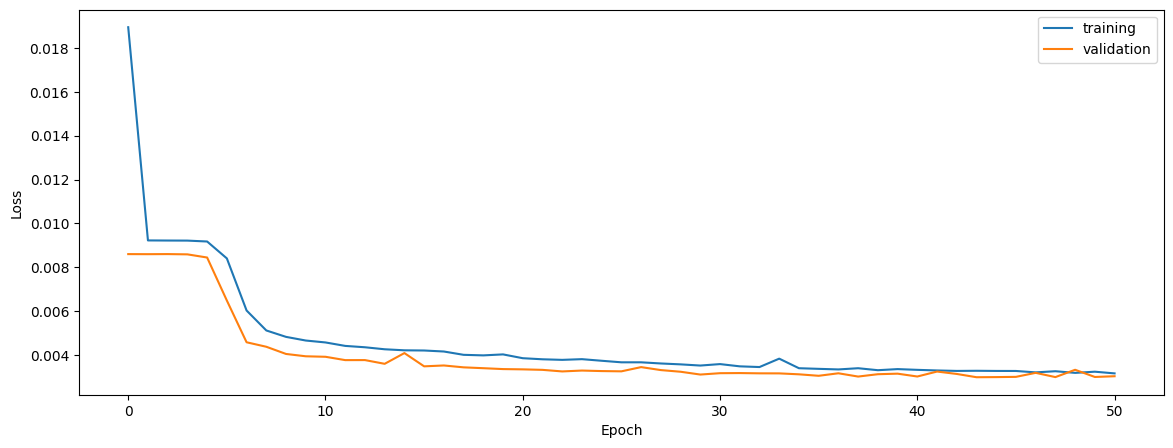

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


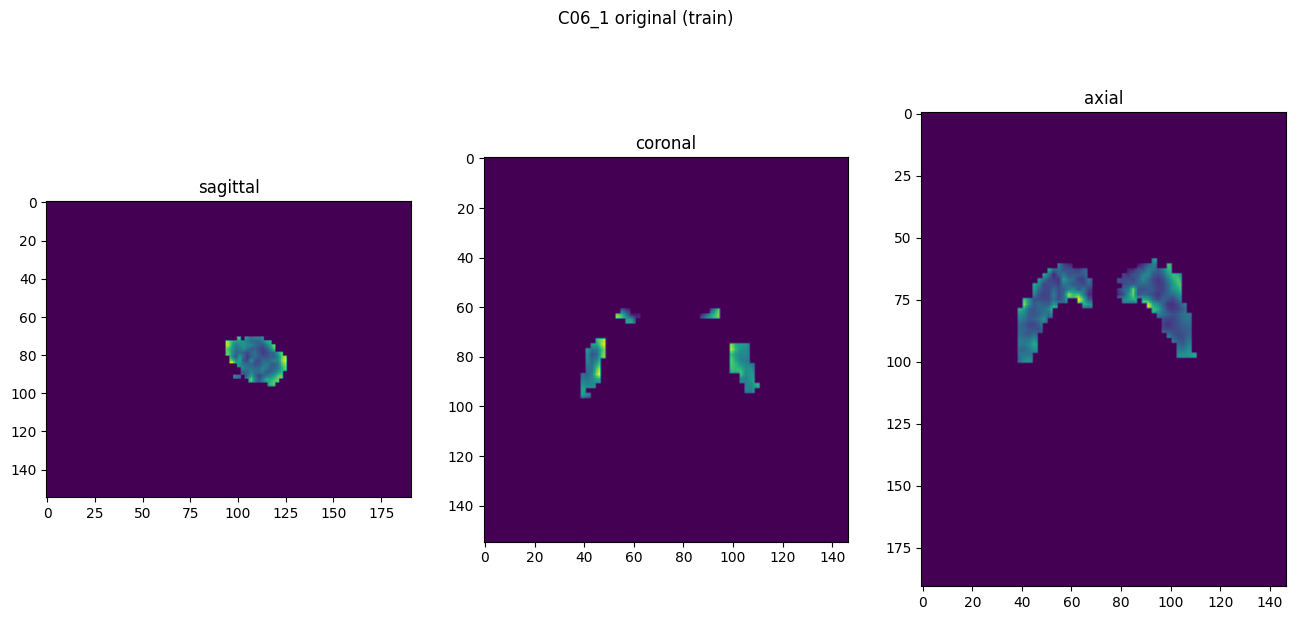

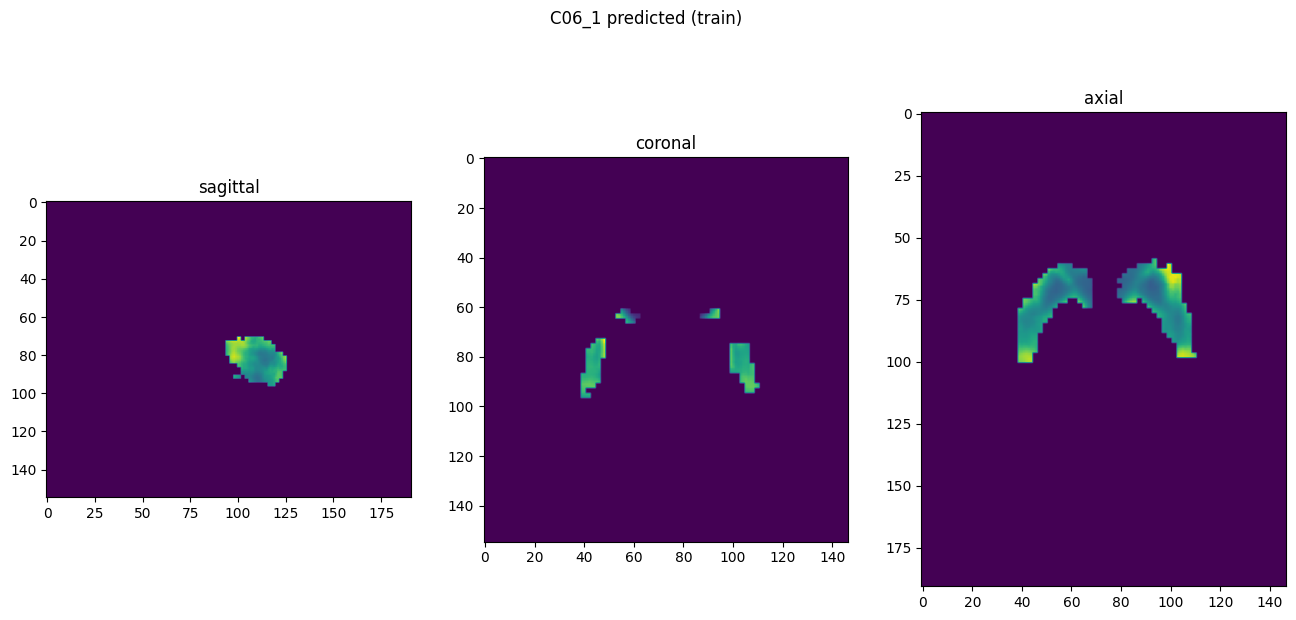

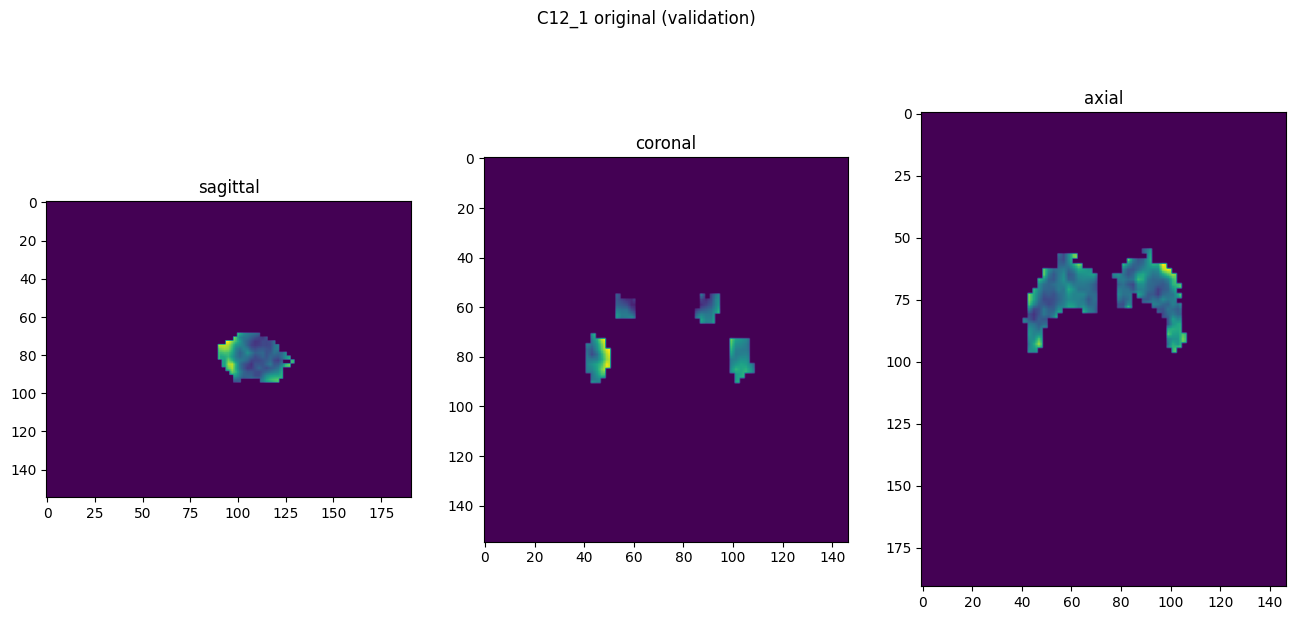

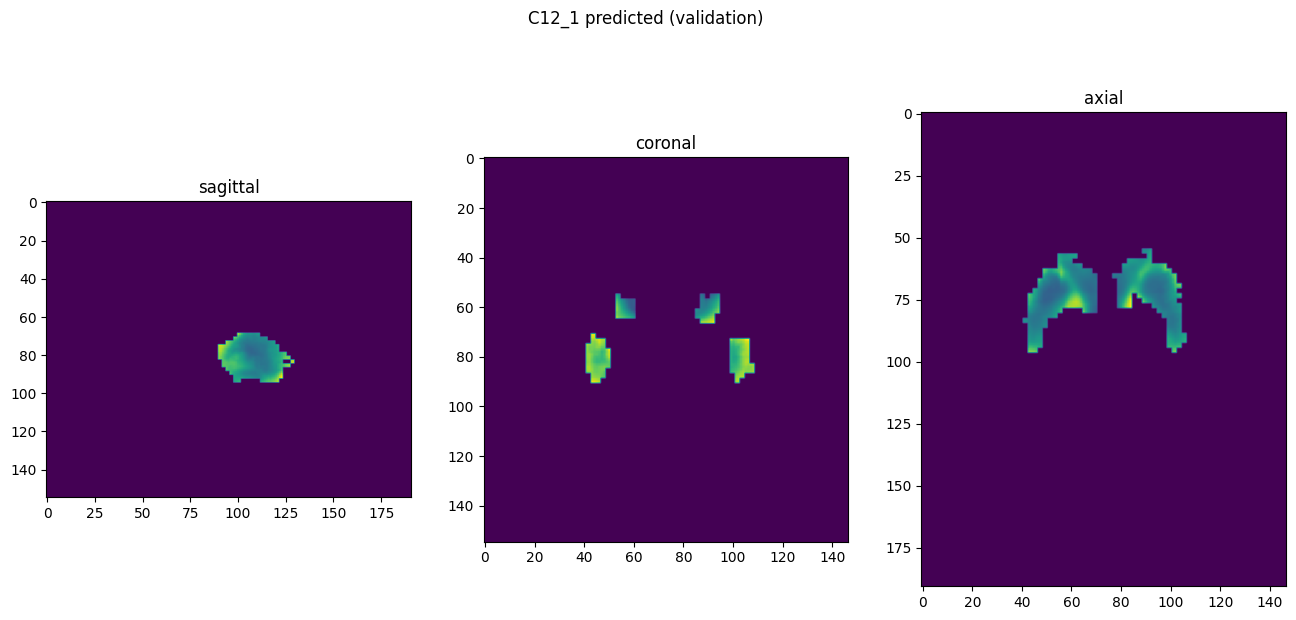

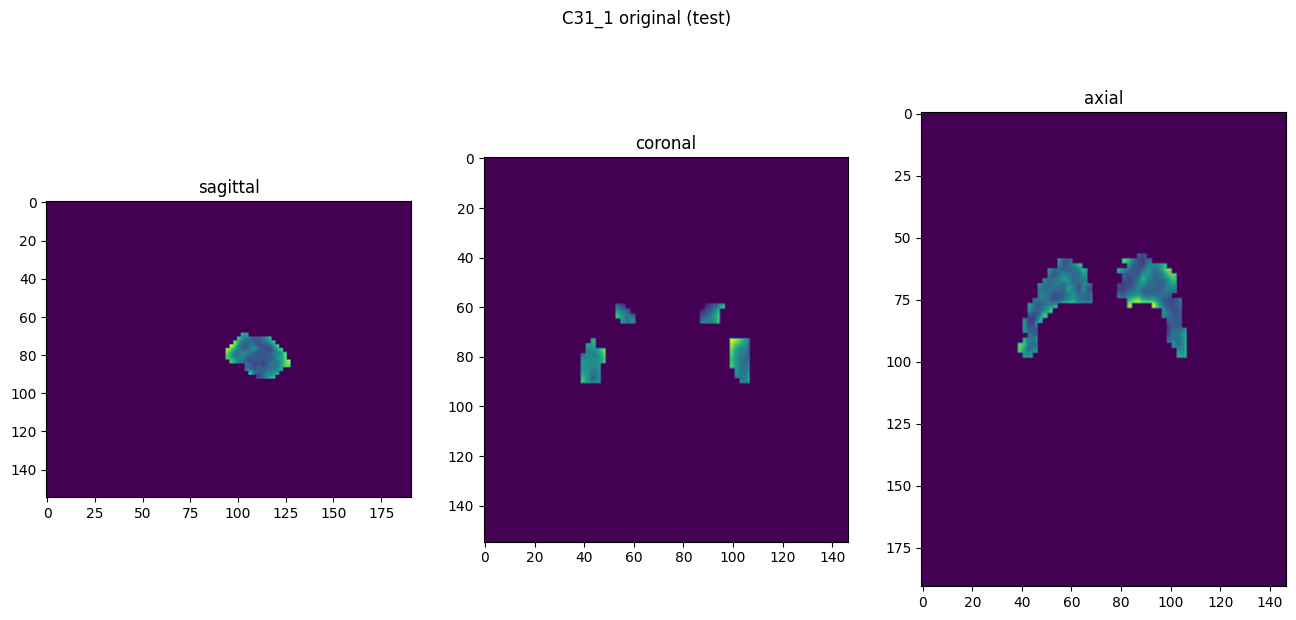

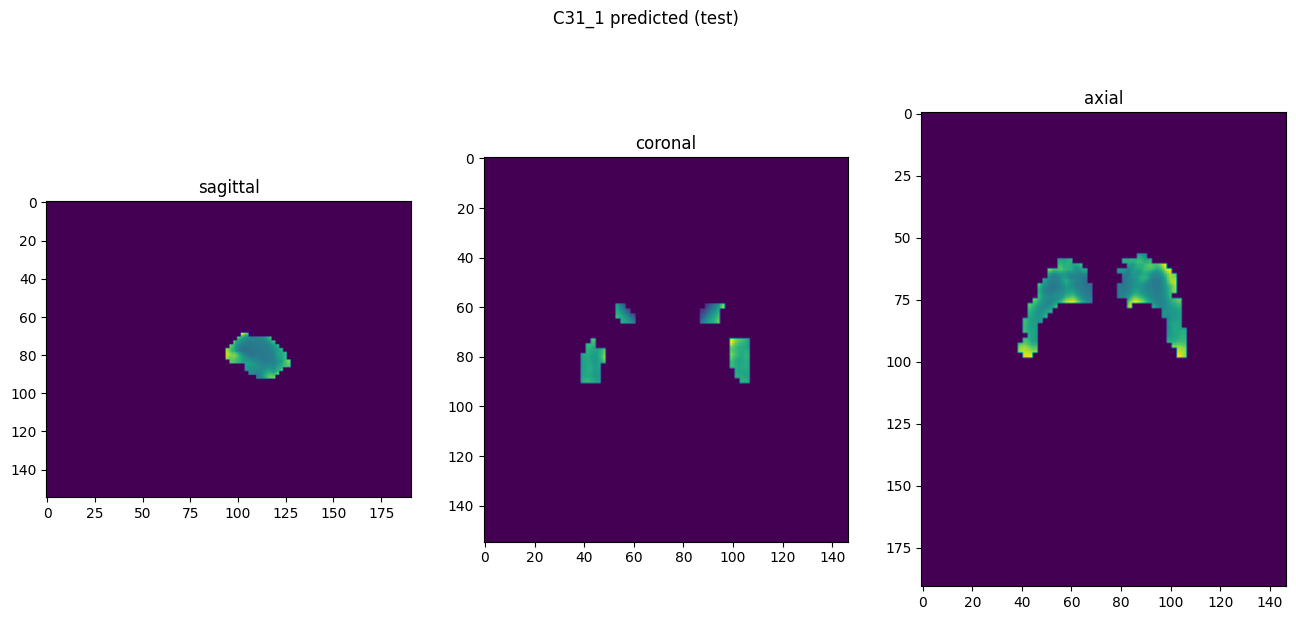

In [10]:
showResults(model, gen, threshold=None, background=False)